In [1]:
import pandas as pd
from seminartools.data import read_inflation

df = read_inflation()
df

,Country Code,IMF Country Code,Country,yearmonth,inflation
8537,ESP,184,Spain,1970-04-01,0.000000
11635,GTM,258,Guatemala,1970-04-01,0.012577
1231,AUS,193,Australia,1970-04-01,0.011236
7708,DOM,243,Dominican Republic,1970-04-01,-0.001604
21697,NZL,196,New Zealand,1970-04-01,0.015421
...,...,...,...,...,...
16098,KOR,542,"Korea, Rep.",2023-01-01,0.010538
15095,JPN,158,Japan,2023-01-01,0.004500
14347,ITA,136,Italy,2023-01-01,0.003938
21470,NOR,142,Norway,2023-01-01,0.006886


/tmp/ipykernel_1215183/2129217928.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_df["pi"] = (1 + country_df["inflation"]).cumprod()


<Axes: xlabel='yearmonth'>

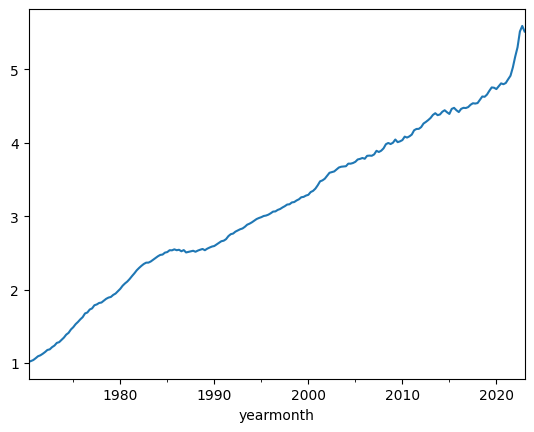

In [2]:
country_df = df[df["Country"] == "Netherlands"]
country_df["pi"] = (1 + country_df["inflation"]).cumprod()
country_df.set_index("yearmonth")["pi"].plot()

In [4]:
len(country_df)

212

In [15]:
import pymc as pm

FIRST_INVERSE_SIGMASQ = 1
GAMMA = 0.2

with pm.Model() as model:
    # pi_t = tau_t + (eta_t = sigma_{eta,t} * N(0, 1))
    # tau_t = tau_{t-1} + (epsilon_t = sigma_{epsilon,t} * N(0, 1))
    # ln sigma_{eta,t}^2 = ln sigma_{eta,t-1}^2 + (nu_eta,t = N(0, gamma))
    # ln sigma_{epsilon,t}^2 = ln sigma_{epsilon,t-1}^2 + (nu_epsilon,t =N(0, gamma))
    pis = []
    taus = []
    log_sigma_eta_sqs = []
    log_sigma_epsilon_sqs = []
    log_sigma_eta_sqs.append(
        pm.Normal("log_sigma_eta_sq_0", mu=0, tau=FIRST_INVERSE_SIGMASQ)
    )
    log_sigma_epsilon_sqs.append(
        pm.Normal("log_sigma_epsilon_sq_0", mu=0, tau=FIRST_INVERSE_SIGMASQ)
    )
    taus.append(
        pm.Normal(
            "tau_0",
            mu=1,
            tau=1
            / pm.math.exp(
                log_sigma_eta_sqs[0]
            ),
        )
    )
    pis.append(
        pm.Normal(
            "pi_0",
            mu=taus[0],
            tau=1
            / pm.math.exp(
                log_sigma_eta_sqs[0]
            ),
            observed=country_df["pi"].values[0],
        )
    )

    for t in range(1, len(country_df)):
        log_sigma_eta_sq = pm.Normal(
            f"log_sigma_eta_sq_{t}", mu=log_sigma_eta_sqs[t - 1], tau=1 / GAMMA
        )
        log_sigma_epsilon_sq = pm.Normal(
            f"log_sigma_epsilon_sq_{t}", mu=log_sigma_epsilon_sqs[t - 1], tau=1 / GAMMA
        )
        sigma_eta_sq = pm.Deterministic(
            f"sigma_eta_sq_{t}", pm.math.exp(log_sigma_eta_sq)
        )
        sigma_epsilon_sq = pm.Deterministic(
            f"sigma_epsilon_sq_{t}", pm.math.exp(log_sigma_epsilon_sq)
        )
        epsilon_t = pm.Normal(f"epsilon_{t}", mu=0, tau=1 / sigma_epsilon_sq)
        tau_t = pm.Deterministic(f"tau_{t}", taus[t - 1] + epsilon_t)
        # pi_t = pm.Deterministic(f"pi_{t}", tau_t + eta_t, observed=country_df["pi"].values[t])
        pi_t = pm.Normal(
            f"pi_{t}",
            mu=tau_t,
            tau=1 / sigma_eta_sq,
            observed=country_df["pi"].values[t],
        )
        pis.append(pi_t)
        taus.append(tau_t)
        log_sigma_eta_sqs.append(log_sigma_eta_sq)
        log_sigma_epsilon_sqs.append(log_sigma_epsilon_sq)

    # trace = pm.sample(1000, tune=1000, cores = 4)

model.basic_RVs

[log_sigma_eta_sq_0,
 log_sigma_epsilon_sq_0,
 tau_0,
 log_sigma_eta_sq_1,
 log_sigma_epsilon_sq_1,
 epsilon_1,
 log_sigma_eta_sq_2,
 log_sigma_epsilon_sq_2,
 epsilon_2,
 log_sigma_eta_sq_3,
 log_sigma_epsilon_sq_3,
 epsilon_3,
 log_sigma_eta_sq_4,
 log_sigma_epsilon_sq_4,
 epsilon_4,
 log_sigma_eta_sq_5,
 log_sigma_epsilon_sq_5,
 epsilon_5,
 log_sigma_eta_sq_6,
 log_sigma_epsilon_sq_6,
 epsilon_6,
 log_sigma_eta_sq_7,
 log_sigma_epsilon_sq_7,
 epsilon_7,
 log_sigma_eta_sq_8,
 log_sigma_epsilon_sq_8,
 epsilon_8,
 log_sigma_eta_sq_9,
 log_sigma_epsilon_sq_9,
 epsilon_9,
 log_sigma_eta_sq_10,
 log_sigma_epsilon_sq_10,
 epsilon_10,
 log_sigma_eta_sq_11,
 log_sigma_epsilon_sq_11,
 epsilon_11,
 log_sigma_eta_sq_12,
 log_sigma_epsilon_sq_12,
 epsilon_12,
 log_sigma_eta_sq_13,
 log_sigma_epsilon_sq_13,
 epsilon_13,
 log_sigma_eta_sq_14,
 log_sigma_epsilon_sq_14,
 epsilon_14,
 log_sigma_eta_sq_15,
 log_sigma_epsilon_sq_15,
 epsilon_15,
 log_sigma_eta_sq_16,
 log_sigma_epsilon_sq_16,
 epsilon_1

In [22]:
N = len(country_df)
with pm.Model() as model:
    log_sigma_eta_sq = pm.Normal("log_sigma_eta_sq", mu=0, tau=FIRST_INVERSE_SIGMASQ, shape=N)
    log_sigma_epsilon_sq = pm.Normal("log_sigma_epsilon_sq", mu=0, tau=FIRST_INVERSE_SIGMASQ, shape=N)
    sigma_eta_sq = pm.Deterministic("sigma_eta_sq", pm.math.exp(log_sigma_eta_sq))
    sigma_epsilon_sq = pm.Deterministic("sigma_epsilon_sq", pm.math.exp(log_sigma_epsilon_sq))
    
    epsilon = pm.Normal("epsilon", mu=0, tau=1 / sigma_epsilon_sq[:-1], shape=N-1)  # Note the shape adjustment
    tau = pm.Deterministic("tau", pm.math.cumsum(pm.math.concatenate([[1], epsilon]), axis=0))
    
    pi = pm.Normal(
        "pi",
        mu=tau,
        tau=1 / sigma_eta_sq,
        observed=country_df["pi"].values
    )

    trace = pm.sample(1000, tune=1000, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma_eta_sq, log_sigma_epsilon_sq, epsilon]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 90 seconds.


/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'log_sigma_eta_sq'}>,
        <Axes: title={'center': 'log_sigma_eta_sq'}>],
       [<Axes: title={'center': 'log_sigma_epsilon_sq'}>,
        <Axes: title={'center': 'log_sigma_epsilon_sq'}>],
       [<Axes: title={'center': 'epsilon'}>,
        <Axes: title={'center': 'epsilon'}>],
       [<Axes: title={'center': 'sigma_eta_sq'}>,
        <Axes: title={'center': 'sigma_eta_sq'}>],
       [<Axes: title={'center': 'sigma_epsilon_sq'}>,
        <Axes: title={'center': 'sigma_epsilon_sq'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>]],
      dtype=object)

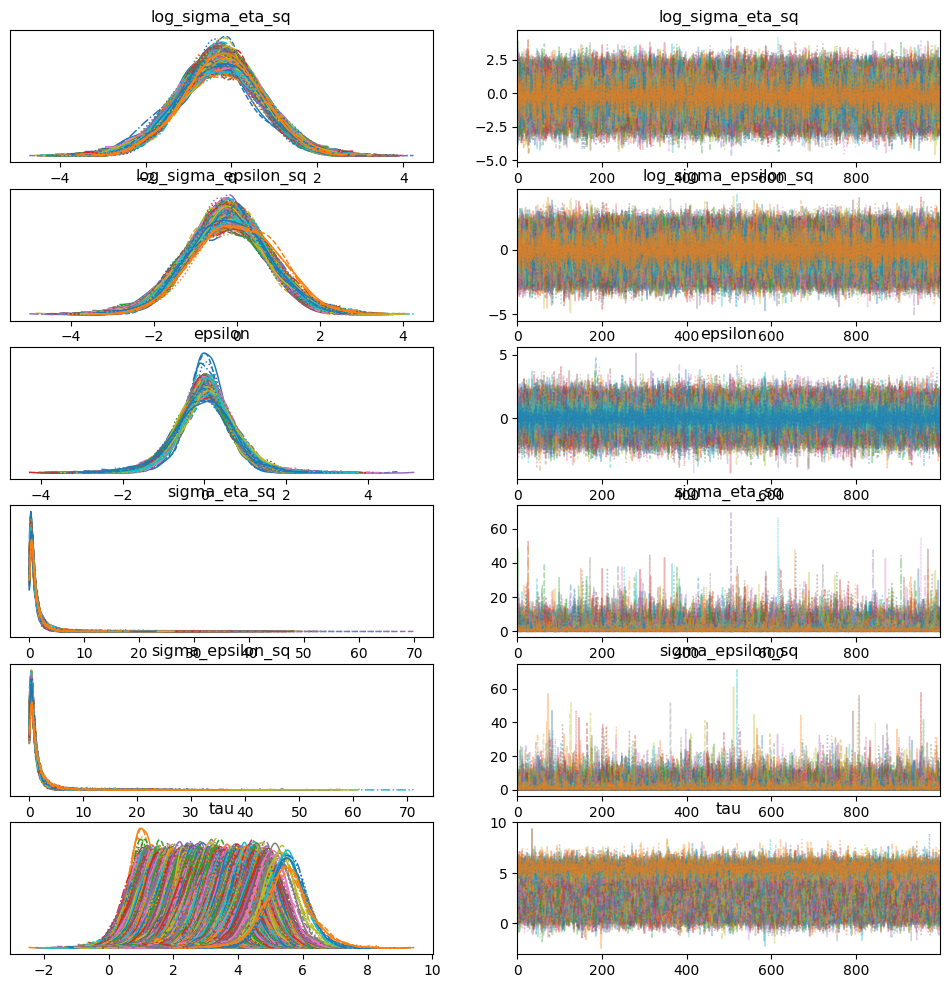

In [26]:
import arviz as az
az.plot_trace(trace)

In [27]:
az.summary(trace)

/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_sigma_eta_sq[0],-0.490,1.008,-2.344,1.462,0.010,0.018,11048.0,2639.0,1.0
log_sigma_eta_sq[1],-0.315,0.936,-1.927,1.540,0.011,0.015,7033.0,2911.0,1.0
log_sigma_eta_sq[2],-0.265,0.976,-2.109,1.569,0.011,0.016,8505.0,3179.0,1.0
log_sigma_eta_sq[3],-0.275,0.950,-2.003,1.540,0.010,0.017,9404.0,2962.0,1.0
log_sigma_eta_sq[4],-0.264,0.950,-2.111,1.447,0.010,0.016,9314.0,3030.0,1.0
...,...,...,...,...,...,...,...,...,...
tau[207],5.175,0.595,4.053,6.331,0.009,0.006,4387.0,3690.0,1.0
tau[208],5.309,0.612,4.185,6.493,0.010,0.007,4134.0,3513.0,1.0
tau[209],5.439,0.611,4.326,6.644,0.009,0.006,4552.0,3509.0,1.0
tau[210],5.528,0.616,4.340,6.641,0.010,0.007,4134.0,3762.0,1.0


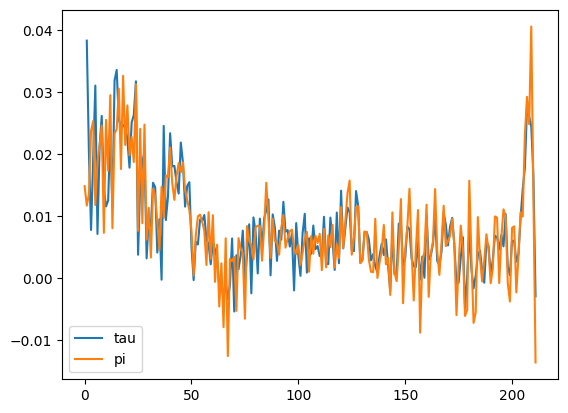

In [47]:
import numpy as np
import matplotlib.pyplot as plt

pd.Series(trace["posterior"]["tau"].mean(axis = 0).mean(axis = 0)).pct_change().plot(label = "tau")
country_df["inflation"].reset_index(drop = True).plot(label = "pi")
plt.legend()



Text(0, 0.5, 'pi')

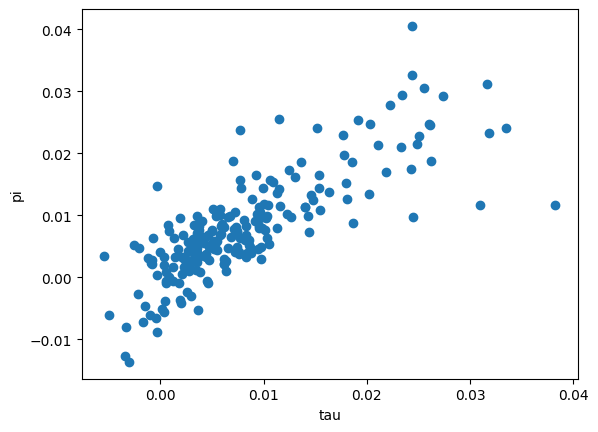

In [52]:
plt.scatter(
    pd.Series(trace["posterior"]["tau"].mean(axis = 0).mean(axis = 0)).pct_change(),
    country_df["inflation"].reset_index(drop = True)
)
plt.xlabel("tau")
plt.ylabel("pi")